<a href="https://colab.research.google.com/github/francescomontagna/MaxEnt-IRL/blob/main/Basic-IRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Classic RL
Use TD Learning to learn a policy that will be used as the expert policy

In [4]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, vmin=0, vmax=10):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

In [93]:
class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0, 10, -1],
      [-1,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1],
    ])
    self._start_state = random.choices(range(1, self._layout.shape[0]-1), k=2)
    while self._start_state == [4, 5]:
      self._start_state = random.choices(range(1, self._layout.shape[0]-1), k=2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap='pink')
    ax = plt.gca() # 'get current axis'
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(8, 3, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  # Environment: given an action as input, return [state, reward]
  def step(self, action):
    y, x = self._state
    
    # Next state
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    # Next reward
    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = 0.9
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    # Add noise to the reward (?)
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()

In [86]:
class classicRLSolver:
  def __init__(self, number_of_states, number_of_actions, initial_state, target_policy, behaviour_policy, double, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
    self._s = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    self._last_action = 0
    
  @property
  def q_values(self):
    if self._double:
      return (self._q + self._q2)/2
    else:
      return self._q

  def step(self, r, g, s):
    """
    Params: 
    r (int): reward value sampled from the environment. Used for the update
    g (float): discount factor
    s (int): next state (t+1) sampled. Bootstrap from s
    Returns:
    next_action (int): refer to Grid() class for action encoding
    """

    if self._double:
      values = [self._q, self._q2]
      random.shuffle(values)
    else:
      values = [self._q, self._q]
    
    a_prime = self._behaviour_policy(values[0][s])

    # Next target action, used for the update
    target_a_prime = self._target_policy(values[0][s], a_prime)

    values[0][self._s, self._last_action] += self._step_size*\
      (r + g*np.dot(values[1][s], target_a_prime) - values[0][self._s, self._last_action])

    # Next action: behaviour - in double-q, sample using updated value
    self._s = s
    self._last_action = a_prime

    return a_prime

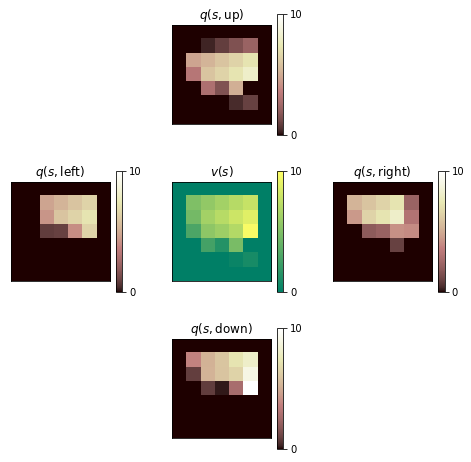

In [94]:
grid = Grid()

def target_policy(q, a):
  """
  :param q: action-value vector for a given state 
  """
  # One hot vector with one for the most valued action
  return np.eye(len(q))[np.argmax(q)]

def behaviour_policy(q):
  return epsilon_greedy(q, 0.1)

agent = classicRLSolver(grid._layout.size, 4, grid.get_obs(),
                 target_policy, behaviour_policy, double=False)
run_experiment(grid, agent, int(1e5))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

In [95]:
expert_q = q[1:-1, 1:-1, :]

# IRL

In [70]:
class GridWorld:
  def __init__(self, grid_size = 5):
    """
    Attributes:
      actions: actions available to the agent (one step in the grid)
      grid_size: size of the side of teh squared grid
      terminal_state: terminal state of the environment
      p_initial: ... ?
      state: state in terms of point ion range(0, geid_size**2)
      state_coord: coordinates of the state in the grid
    """

    self.actions = [0, 1, 2, 3] # [up, right, down, left]
    self.grid_size = grid_size
    self.layout = np.zeros((grid_size, grid_size))
    self.terminal_state = (3, 4)
    self.p_initial = np.zeros(self.layout.shape)*(1/self.grid_size**2) # must be computed form trajectories

    self.reset()

  def state_coord_to_point(self, state_coord):
    return state_coord[0]*self.grid_size + state_coord[1]

  # TODO: test
  def point_to_state_coord(self, point):
    row = point // self.grid_size
    col = point % self.grid_size
    return row, col

  #TODO: test
  def simulate_step(self, action, point = True):
    self.state_coord = self.state_coord
    next_s_coord = None

    if action == 0:
      if self.state_coord[0] == 0:
        next_s_coord = self.state_coord
      else:
        next_s_coord = (self.state_coord[0]-1, self.state_coord[1])

    elif action == 1:
      if self.state_coord[1] == (self.grid_size-1):
        next_s_coord = self.state_coord
      else:
        next_s_coord = (self.state_coord[0], self.state_coord[1]+1)
      
    elif action == 2:
      if self.state_coord[0] == (self.grid_size-1):
        next_s_coord = self.state_coord
      else:
        next_s_coord = (self.state_coord[0]+1, self.state_coord[1])

    elif action == 3:
      if self.state_coord[1] == 0:
        next_s_coord = self.state_coord
      else:
        next_s_coord = (self.state_coord[0], self.state_coord[1]-1)

    if point:
      return self.state_coord_to_point(next_s_coord)
    
    return next_s_coord

  def step(self, action, point = False):
    next_state = self.simulate_step(action, point)
    self.state_coord = next_state
    self.state = self.state_coord_to_point(next_state)

    return next_state # coord

  # Initialize the gridworld
  def reset(self):
    initial_state = random.choice(range(self.grid_size**2))
    while (self.point_to_state_coord(initial_state)) == self.terminal_state:
      initial_state = random.choice(range(self.grid_size**2))
    self.state_coord = self.point_to_state_coord(initial_state)
    self.initial_state = self.point_to_state_coord(initial_state)
    self.state = initial_state

In [53]:
class Trajectories:
  def __init__(self, num_samples, world, expert_q):
    self.world = world
    self.num_samples = num_samples
    self.trajectories = []
    self.expert_q = expert_q

    self.s = self.world.state # point

  def sample_trajectories(self):
    terminal_state = self.world.terminal_state # coord
    for _ in range(self.num_samples):
      self.world.reset()
      state_coord = self.world.state_coord 
      trajectory = []
      while state_coord != terminal_state:
        row, col = state_coord
        action = np.argmax(self.expert_q[row, col])
        trajectory.append((state_coord, action))
        state_coord = self.world.step(action, point = False)

      # Do not store the terminal state, since it is unique
      self.trajectories.append(trajectory)

    return self.trajectories

In [65]:
class MaxCausalEntropy:
  # We'll consider the case of a deterministic policy
  def __init__(self, trajectories, lr, decay):
    """
    Attributes:
      trajectories: list of the sampeld trajectories
      lr: learning rate for SGA
      decay: weight decay for SGA
      world: The environment modeled as GridWorld
      features: feature to represrent each state. Simply encoded as coordinates in the grid
      theta: learnable parameters, one vector for each possible state. Same dimensionality of features
      V: (n_states x n_states) matrix with value associated to each state
      D: (n_states x n_states) matrix with visitation frequencies
      gamma: discount (Forse dev'essere ritornato da simulate_step, decido poi)
    """
    self.trajectories = trajectories
    self.lr = lr
    self.decay = decay

    self.world = GridWorld()
    self.n_states = self.world.grid_size**2
    self.features = np.zeros((self.n_states, 2))
    for s in range(self.n_states):
      i, j = self.world.point_to_state_coord(s)
      self.features[s, 0] = i
      self.features[s, 1] = j

    self.theta = np.zeros((self.n_states, 2)) # np.matmul(self.theta[i, j], self.features[i, j]) = R(s=[i,j])
    self.V = np.zeros((self.n_states))
    self.D = np.zeros((self.n_states))

    self.gamma = 0.9
    

  def R(self, state):
    """
    Return reward associated to given state (point)
    """
    return np.matmul(self.theta[s], self.features[s])

  # def Q(self, state, action):
  #   """
  #   Return action value associated to given state (point)
  #   Maximize over action to get Q(S, A)
  #   """
  #   next_s = self.world.simulate_step(state, action)
  #   return self.R(state) + self.gamma * self.V[next_s]

  def policy(self, state, action):
    return np.exp(self.Q(state, action) - self.V[state])
    
  def feature_exp_from_trajectories(self):
    # Compute feature_exp, as a representation of expert behaviour
    _, features_dim = self.features.shape
    f_exp = np.zeros((features_dim))

    for trajectory in self.trajectories:
      for step in trajectory:
        state, action = step
        f_exp += self.features[state] # TODO: check if it's point or coord

    return f_exp / len(self.trajectories)


  def pseudo_gpi(self):
    """
    Algorithm to update the value function
    """
    # NOTE: state = point in range(self.num_states)
    eps = 1e-3
    
    # For each state, define set V to -inf
    self.V = np.ones((self.n_states))*np.min

    # Set V_prime to -inf except for termnal state which is set to 0
    V_prime = np.ones((self.n_states))*np.min
    v_prime[self.world.state_coord_to_point(self.terminal_state)] = 0

    delta = np.ones((self.num_states))*np.max # parameter to monitor convergence
    while np.max(delta) > eps:
      # Update V for each state
      for s in range(self.num_states):
        for a in self.world.actions:
          next_s = self.world.simulate_step(s, a)
          V_prime[s] = np.log(np.exp(V_prime[s]) + np.exp(self.R(s) + self.V[next_s]))

        delta[s] = np.abs(self.V[s] - V_prime[s])
        self.V[s] = V_prime[s]

    # return self.V 

  def expected_svf(self):
    eps = 1e-5

    self.D = np.zeros((n_states))
    D_prime = world.p_initial # TODO Handle copy (shallow, deep, .. boh)

    delta = np.ones((self.num_states))*np.max
    while np.max(delta) > eps:
      for s in range(self.num_states):
        for a in self.world.actions:
          next_s = self.world.simulate_step(s, a)
          D_prime[s] += self.D[s]*self.policy(next_s, a)

        delta[s] = np.abs(self.D[s] - D_prime[s])
        self.D[s] = D_prime[s]
           
    # return self.D[s]

  def sga(self):
    eps = 1e-4
    delta = np.zeros(self.features.shape)
    decay = self.decay
    f_exp_from_t  = self.feature_exp_from_trajectories()
    while np.max(delta) > eps:
      for state in range(self.num_states):
        gradient = self.features[state]*self.D[state] # Not sure this is right..., non c'è traccia delle azioni
        update = np.exp(-(self.lr/decay)*(f_exp_from_t - gradient))
        delta[state] = np.abs(self.theta[state] - self.theta[state]*update)
        self.theta[state] *= update

    # return self.theta

In [97]:
T = Trajectories(num_samples=200, world = GridWorld(), expert_q=expert_q)
trajectories = T.sample_trajectories()

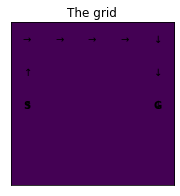

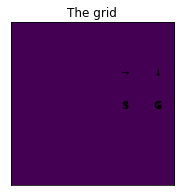

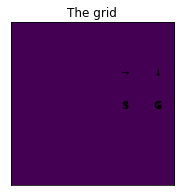

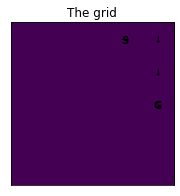

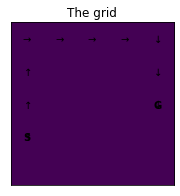

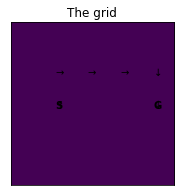

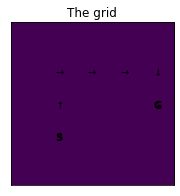

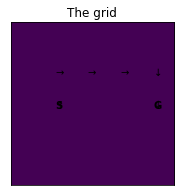

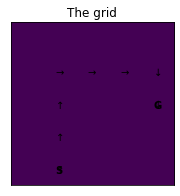

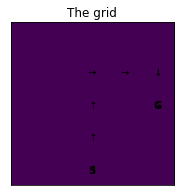

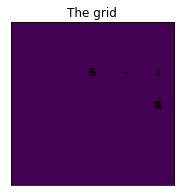

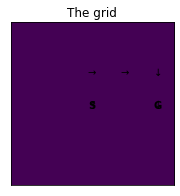

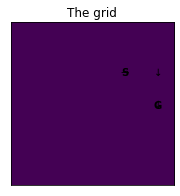

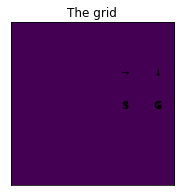

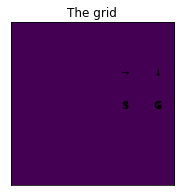

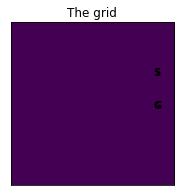

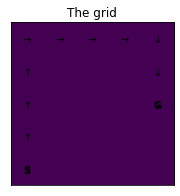

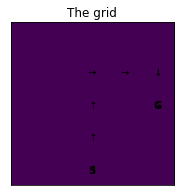

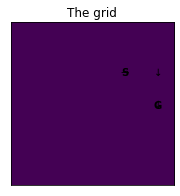

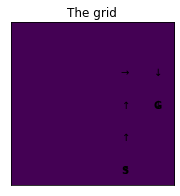

In [128]:
def plot_trajectory(world, t):
  plt.figure(figsize=(3, 3))
  plt.imshow(world.layout > -1, interpolation="nearest")     
  ax = plt.gca()
  ax.grid(0)
  plt.xticks([])
  plt.yticks([])
  plt.title("The grid")

  start = t[0][0]
  end = t[-1][0]
  plt.text(
      start[1], start[0], 
      r"$\mathbf{S}$", ha='center', va='center')
  plt.text(
      end[1], end[0], 
      r"$\mathbf{G}$", ha='center', va='center')

  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]

  for state, action in t:
    action_name = action_names[action]
    plt.text(state[1], state[0], action_name, ha='center', va='center')


for t in trajectories[0:20]:
  plot_trajectory(GridWorld(), t)